# Analyse Flight Data
- This project will explore the flight data and try to forecast a flight predict whether a flight will be delayed

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

# Load data

The dataset was downloaded from https://www.kaggle.com/datasets/irina464520/flightdatacsv/

In [7]:
flight = pd.read_csv('flightdata.csv')
flight.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


# Explore data

This dataset contains 26 columns. It shows the flight status of Delta Airlines in the United States during a certain period of time (DL is the IATA code of Delta Airlines).

Here are info for each column in dataset:
| Column | Description |
| --- | --- |
| YEAR | Year of the flight |
| QUARTER | Quarter of the flight (1-4) |
| MONTH | Month of the flight (1-12) |
| DAY_OF_MONTH | Day of the month of the flight (1-31) |
| DAY_OF_WEEK | Day of the week of the flight (1 = Monday, 2 = Tuesday, etc.) |
| UNIQUE_CARRIER | Airline code (e.g., DL) |
| TAIL_NUM | Aircraft tail number |
| FL_NUM | Flight number |
| ORIGIN_AIRPORT_ID | Origin airport ID |
| ORIGIN | Origin airport code (ATL, DFW, SEA, etc.) |
| DEST_AIRPORT_ID | Destination airport ID |
| DEST | Destination airport code (ATL, DFW, SEA, etc.) |
| CRS_DEP_TIME | Scheduled departure time |
| DEP_TIME | Actual departure time |
| DEP_DELAY | Departure delay in minutes |
| DEP_DEL15 | 0 = Departure delay less than 15 minutes, 1 = Departure delay 15 minutes or longer |
| CRS_ARR_TIME | Scheduled arrival time |
| ARR_TIME | Actual arrival time |
| ARR_DELAY | Arrival delay in minutes |
| ARR_DEL15 | 0 = Arrival delay less than 15 minutes, 1 = Arrival delay 15 minutes or longer |
| CANCELLED | 0 = Flight not cancelled, 1 = Flight cancelled |
| DIVERTED | 0 = Flight not diverted, 1 = Flight diverted |
| CRS_ELAPSED_TIME | Scheduled flight time in minutes |
| ACTUAL_ELAPSED_TIME | Actual flight time in minutes |
| DISTANCE | Flight distance in miles |


- Delayed flights group by month

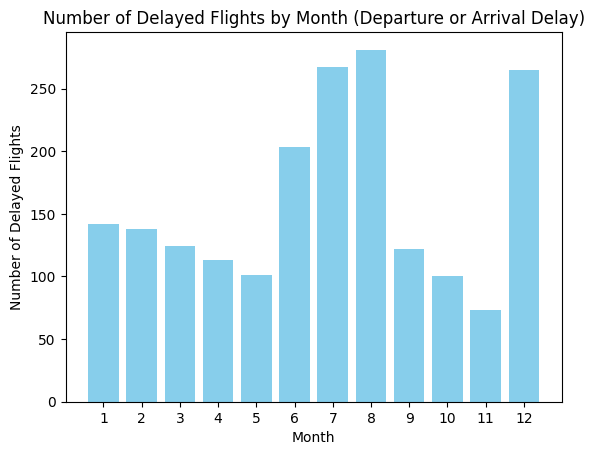

In [8]:
# Filter flights with either departure delay of 15 minutes or longer OR arrival delay of 15 minutes or longer
delayed_flights = flight[(flight['DEP_DELAY'] >= 15) | (flight['ARR_DELAY'] >= 15)]

# Group by month and count delayed flights for each month
delayed_flights_by_month = delayed_flights.groupby('MONTH').size().reset_index(name='DelayedFlights')

# Plotting the bar chart
plt.bar(delayed_flights_by_month['MONTH'], delayed_flights_by_month['DelayedFlights'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Delayed Flights')
plt.title('Number of Delayed Flights by Month (Departure or Arrival Delay)')
plt.xticks(delayed_flights_by_month['MONTH'])
plt.show()

- Delayed, cancelled and diverted flights group by month

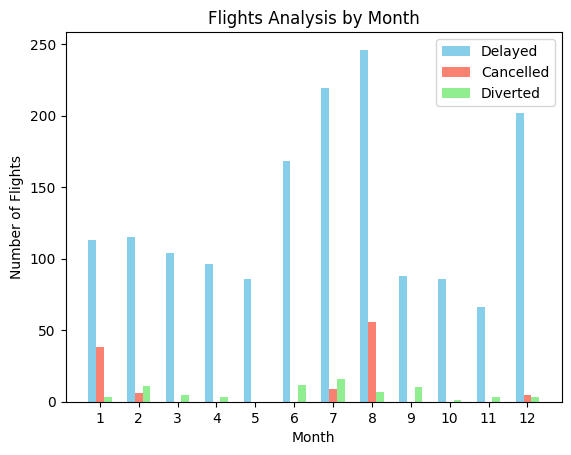

In [9]:
# Filter flights with departure delay of 15 minutes or longer
delayed_flights = flight[flight['DEP_DELAY'] >= 15]

# Filter cancelled flights
cancelled_flights = flight[flight['CANCELLED'] == 1]

# Filter diverted flights
diverted_flights = flight[flight['DIVERTED'] == 1]

# Group by month and count flights for each category
delayed_by_month = delayed_flights.groupby('MONTH').size().reset_index(name='DelayedFlights')
cancelled_by_month = cancelled_flights.groupby('MONTH').size().reset_index(name='CancelledFlights')
diverted_by_month = diverted_flights.groupby('MONTH').size().reset_index(name='DivertedFlights')

# Merging the dataframes on 'MONTH'
result = pd.merge(delayed_by_month, cancelled_by_month, on='MONTH', how='outer')
result = pd.merge(result, diverted_by_month, on='MONTH', how='outer')

# Fill NaN values with 0
result = result.fillna(0)

# Plotting the bar chart
bar_width = 0.2
plt.bar(result['MONTH'] - bar_width, result['DelayedFlights'], width=bar_width, label='Delayed', color='skyblue')
plt.bar(result['MONTH'], result['CancelledFlights'], width=bar_width, label='Cancelled', color='salmon')
plt.bar(result['MONTH'] + bar_width, result['DivertedFlights'], width=bar_width, label='Diverted', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.title('Flights Analysis by Month')
plt.xticks(result['MONTH'])
plt.legend()
plt.show()

- Number of delayed flights in each depart airport

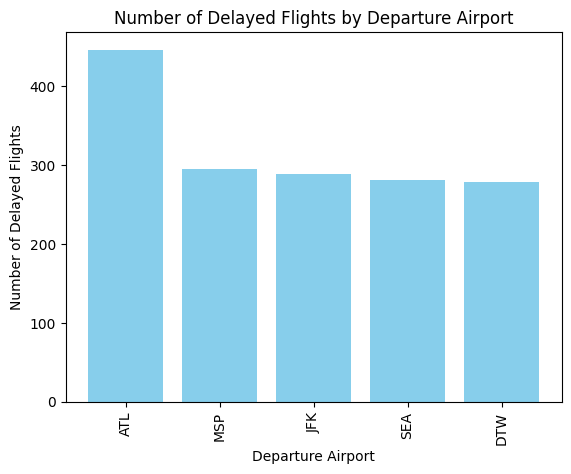

In [10]:
# Filter flights with departure delay of 15 minutes or longer
delayed_flights = flight[flight['DEP_DELAY'] >= 15]

# Group by departure airport and count delayed flights for each airport
delayed_flights_by_airport = delayed_flights.groupby('ORIGIN')['DEP_DELAY'].count().reset_index(name='DelayedFlights')

# Sorting the data by the number of delayed flights in descending order
delayed_flights_by_airport = delayed_flights_by_airport.sort_values(by='DelayedFlights', ascending=False)

# Plotting the bar chart
plt.bar(delayed_flights_by_airport['ORIGIN'], delayed_flights_by_airport['DelayedFlights'], color='skyblue')
plt.xlabel('Departure Airport')
plt.ylabel('Number of Delayed Flights')
plt.title('Number of Delayed Flights by Departure Airport')
plt.xticks(rotation=90)
plt.show()

- Relationship between dep_delay and arr_delay

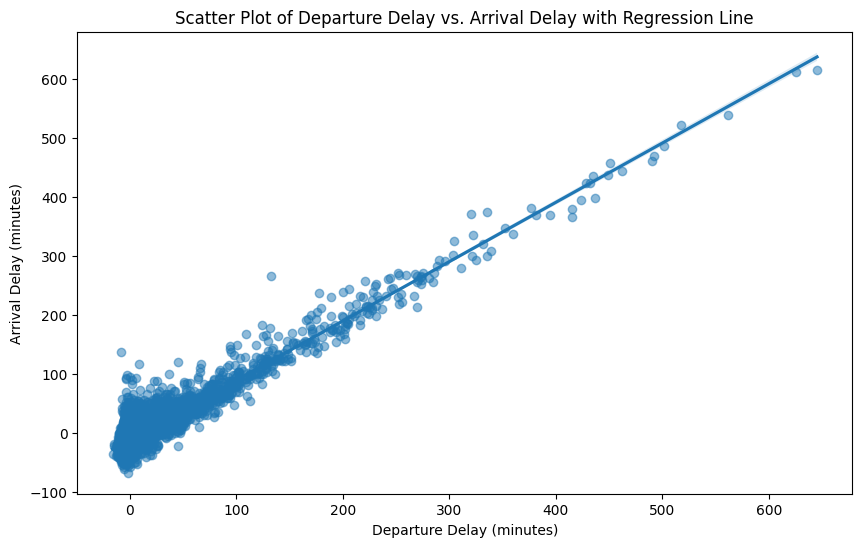

Correlation Coefficient: 0.9352678168069861


In [11]:
# Filter out rows with missing values in DEP_DELAY or ARR_DELAY
delay_data = flight[['DEP_DELAY', 'ARR_DELAY']].dropna()

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='DEP_DELAY', y='ARR_DELAY', data=delay_data, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot of Departure Delay vs. Arrival Delay with Regression Line')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

# Calculate correlation coefficient
correlation_coefficient = delay_data['DEP_DELAY'].corr(delay_data['ARR_DELAY'])
print(f'Correlation Coefficient: {correlation_coefficient}')

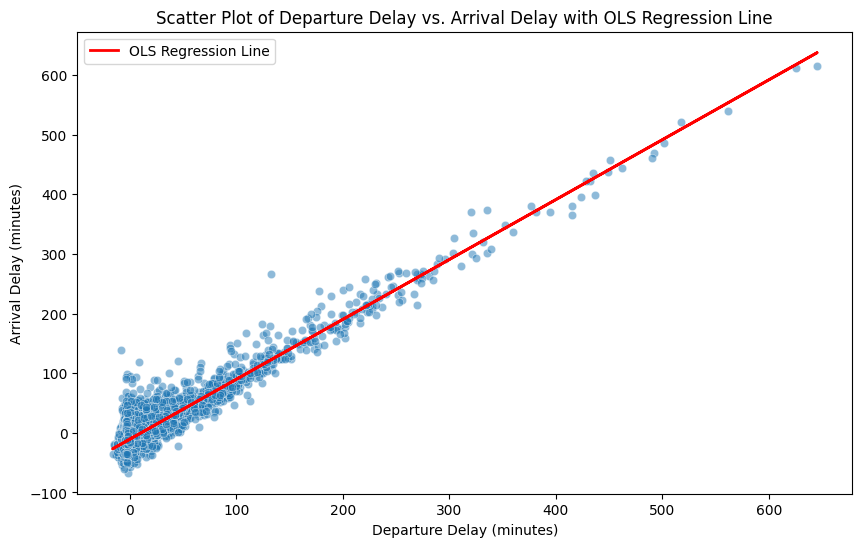

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 7.709e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:45:10   Log-Likelihood:                -44722.
No. Observations:               11043   AIC:                         8.945e+04
Df Residuals:                   11041   BIC:                         8.946e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9789      0.136    -80.983      0.0

In [12]:
# Filter out rows with missing values in DEP_DELAY or ARR_DELAY
delay_data = flight[['DEP_DELAY', 'ARR_DELAY']].dropna()

# Scatter plot with OLS regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DEP_DELAY', y='ARR_DELAY', data=delay_data, alpha=0.5)

# Fit OLS regression line
X = sm.add_constant(delay_data['DEP_DELAY'])
model = sm.OLS(delay_data['ARR_DELAY'], X).fit()

# Add regression line to the plot
plt.plot(delay_data['DEP_DELAY'], model.predict(X), color='red', linewidth=2, label='OLS Regression Line')

plt.title('Scatter Plot of Departure Delay vs. Arrival Delay with OLS Regression Line')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.show()

# Display OLS summary
print(model.summary())

It has a strong relatinship betweem dep_delay and arr_delay

- Relationship between dep_delay and diverted

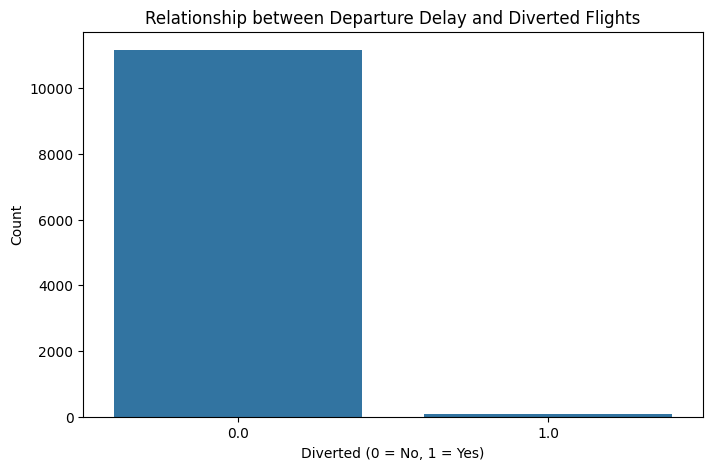

Correlation Coefficient between DEP_DELAY and DIVERTED: 0.014858891485187667


In [13]:
# Create a count plot to show the relationship
plt.figure(figsize=(8, 5))
sns.countplot(x='DIVERTED', data=flight)
plt.title('Relationship between Departure Delay and Diverted Flights')
plt.xlabel('Diverted (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Calculate the correlation coefficient
correlation_coefficient = flight['DEP_DELAY'].corr(flight['DIVERTED'])

print(f'Correlation Coefficient between DEP_DELAY and DIVERTED: {correlation_coefficient}')

No relation

- Relation between actual_elapsed_time and dep_delay or arr_delay

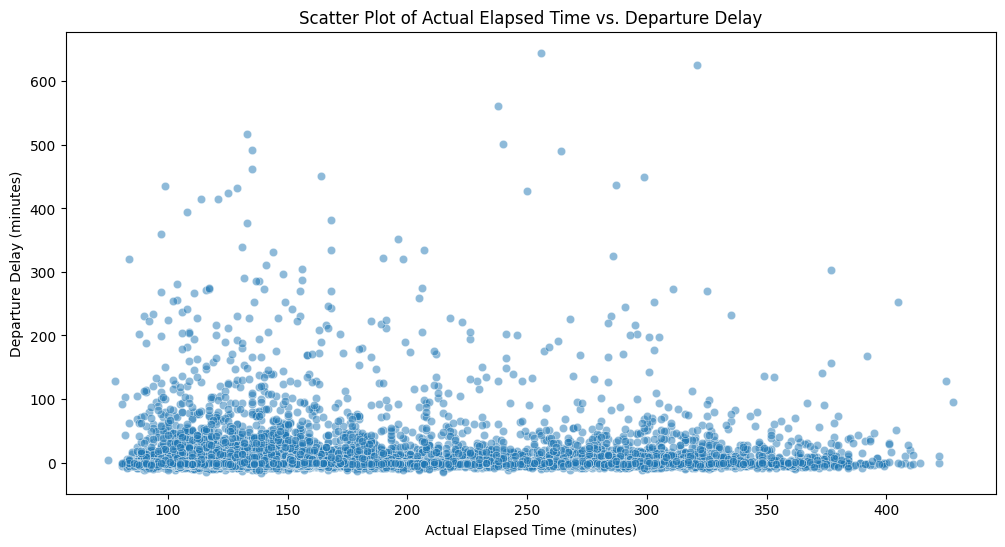

                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.476
Date:                Sun, 19 Nov 2023   Prob (F-statistic):              0.224
Time:                        16:45:10   Log-Likelihood:                -55393.
No. Observations:               11043   AIC:                         1.108e+05
Df Residuals:                   11041   BIC:                         1.108e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.3886    

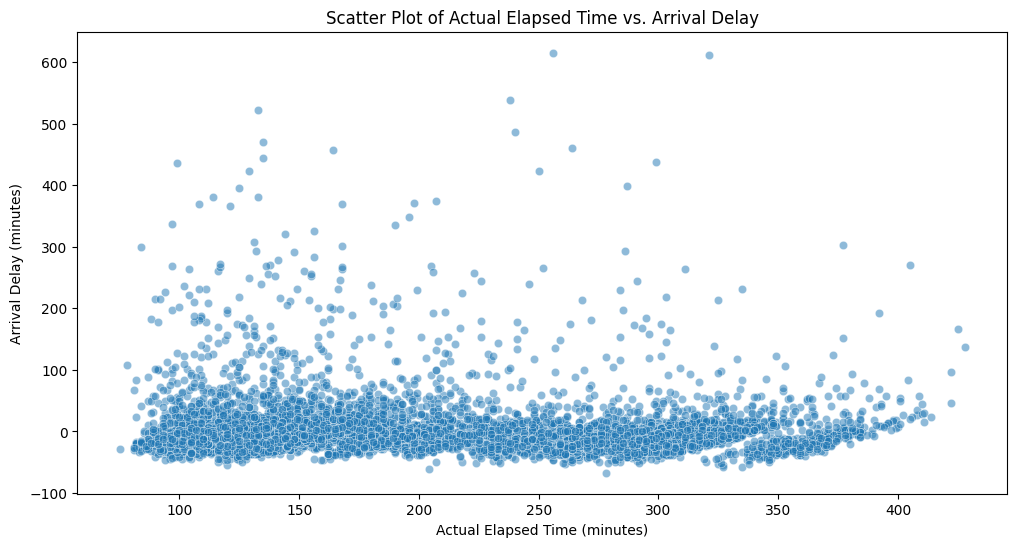

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.879
Date:                Sun, 19 Nov 2023   Prob (F-statistic):            0.00168
Time:                        16:45:10   Log-Likelihood:                -56186.
No. Observations:               11043   AIC:                         1.124e+05
Df Residuals:                   11041   BIC:                         1.124e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.2771    

In [14]:
# Filter out rows with missing values in ACTUAL_ELAPSED_TIME, DEP_DELAY, or ARR_DELAY
data = flight[['ACTUAL_ELAPSED_TIME', 'DEP_DELAY', 'ARR_DELAY']].dropna()

# Scatter plot of ACTUAL_ELAPSED_TIME vs. DEP_DELAY
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ACTUAL_ELAPSED_TIME', y='DEP_DELAY', data=data, alpha=0.5)
plt.title('Scatter Plot of Actual Elapsed Time vs. Departure Delay')
plt.xlabel('Actual Elapsed Time (minutes)')
plt.ylabel('Departure Delay (minutes)')
plt.show()

# OLS regression for ACTUAL_ELAPSED_TIME and DEP_DELAY
X_dep_delay = sm.add_constant(data['ACTUAL_ELAPSED_TIME'])
model_dep_delay = sm.OLS(data['DEP_DELAY'], X_dep_delay).fit()

# Display OLS summary for DEP_DELAY
print(model_dep_delay.summary())

# Scatter plot of ACTUAL_ELAPSED_TIME vs. ARR_DELAY
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ACTUAL_ELAPSED_TIME', y='ARR_DELAY', data=data, alpha=0.5)
plt.title('Scatter Plot of Actual Elapsed Time vs. Arrival Delay')
plt.xlabel('Actual Elapsed Time (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

# OLS regression for ACTUAL_ELAPSED_TIME and ARR_DELAY
X_arr_delay = sm.add_constant(data['ACTUAL_ELAPSED_TIME'])
model_arr_delay = sm.OLS(data['ARR_DELAY'], X_arr_delay).fit()

# Display OLS summary for ARR_DELAY
print(model_arr_delay.summary())

No relation

# Prepare data

**Clean data**

In [15]:
# Find if data has missing value
flight.isnull().values.any()

True

In [16]:
# Count missing value for each column
flight.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

Unnamed: 25            11231
<hr>
This column has 11231 missing values, same size as dataset. Here we need to drop this column since there's no data inside.

In [17]:
flight = flight.drop('Unnamed: 25', axis=1)
flight.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

Here we start filtering columns that meet the model requirements.

In [18]:
flight_data = flight[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
flight_data.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [19]:
# List missing value
display(flight_data[flight_data.isnull().values.any(axis=1)].head())

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


You can see that columns with missing values are represented by 0 or 1, and these flights are canceled or diverted. So we decided to fill in these missing values with a value of 1 (representing a flight delay).

In [20]:
# Fill missing values in ARR_DEL15 with 1
flight['ARR_DEL15'].fillna(1, inplace=True)

# Verify that missing values are filled
print(flight[['ARR_DEL15']].isnull().sum())

ARR_DEL15    0
dtype: int64


**Draw boxplot**

In [21]:
def identify_outliers(df, column_name, replace_outliers):
    """
    Identify and display outliers for a specified column in a DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: str, name of the column for which outliers are to be identified
    - replace_outliers: bool, whether to replace outliers with the average value (default is True)

    Returns:
    - None
    """
    # Boxplot for the specified column
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column_name])
    plt.title(f"Boxplot of {column_name}")
    plt.show()

    # Calculate Z-scores for the specified column
    z_scores_column = zscore(df[column_name])

    # Set a Z-score threshold for outlier detection
    z_score_threshold_column = 3

    # Identify outliers using Z-scores
    outliers_column = (np.abs(z_scores_column) > z_score_threshold_column)

    if replace_outliers:
        max_iterations = 3  # Set a maximum number of iterations
        iterations = 0
        while outliers_column.sum() > 0 and iterations < max_iterations:
            # Replace outliers with the average value of the column
            average_value = df.loc[~outliers_column, column_name].mean()
            df.loc[outliers_column, column_name] = average_value

            # Re-calculate Z-scores and identify outliers
            z_scores_column = zscore(df[column_name])
            outliers_column = (np.abs(z_scores_column) > z_score_threshold_column)
            iterations += 1

    # Display rows with outliers for the specified column
    print(f"\nRows with {column_name} outliers:")
    display(df[outliers_column])

    # Display the count of outliers for the specified column
    print(f"\nCount of {column_name} outliers:")
    print(outliers_column.sum())

In [22]:
flight_data

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0
...,...,...,...,...,...,...,...
11226,12,30,5,DTW,ATL,1005,0.0
11227,12,30,5,SEA,MSP,1525,0.0
11228,12,30,5,DTW,SEA,1959,0.0
11229,12,30,5,ATL,SEA,1530,0.0


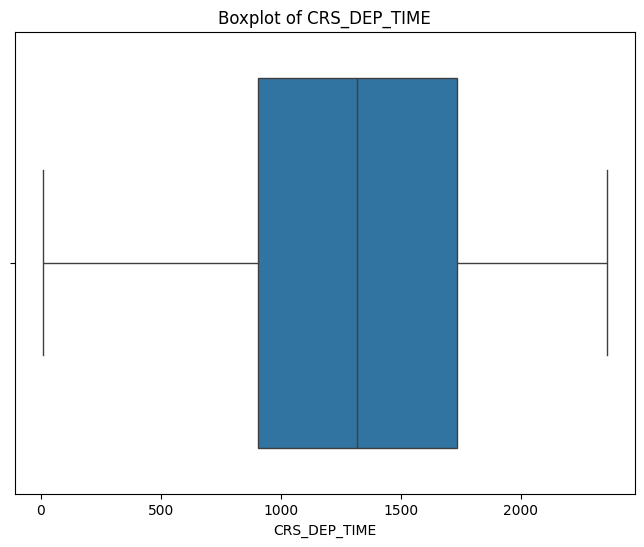


Rows with CRS_DEP_TIME outliers:


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15



Count of CRS_DEP_TIME outliers:
0


In [23]:
identify_outliers(flight_data, 'CRS_DEP_TIME', False)

In [24]:
# Binning CRS_DEP_TIME
# Here we will remvoe minute in time
for index, row in flight_data.iterrows():
    flight_data.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
flight_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


In [25]:
# Change ORIGIN and DEST value 
flight_data = pd.get_dummies(flight_data, columns=['ORIGIN', 'DEST'])
flight_data

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,True,False,False,False,False,False,False,False,False,True
1,1,1,5,13,0.0,False,True,False,False,False,False,False,False,True,False
2,1,1,5,9,0.0,True,False,False,False,False,False,False,False,False,True
3,1,1,5,8,0.0,False,False,False,False,True,False,False,False,True,False
4,1,1,5,23,0.0,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11226,12,30,5,10,0.0,False,True,False,False,False,True,False,False,False,False
11227,12,30,5,15,0.0,False,False,False,False,True,False,False,False,True,False
11228,12,30,5,19,0.0,False,True,False,False,False,False,False,False,False,True
11229,12,30,5,15,0.0,True,False,False,False,False,False,False,False,False,True


# Train mdoel

Here we choose these models: Random Forest, Gradient Boosting Machine, Nerual Network

In [26]:
target = 'ARR_DEL15'

X = flight_data.drop("ARR_DEL15", axis=1)
y = flight_data[target]

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [28]:
# Drop rows with NaN values in y_train
X_train = X_train[~y_train.isnull()]
y_train = y_train.dropna()

# Drop rows with NaN values in y_test
X_test = X_test[~y_test.isnull()]
y_test = y_test.dropna()


In [29]:
display(y_train.isnull().sum())
display(y_test.isnull().sum())

0

0

- Random Forest

In [30]:
# Random Forest
model_rf = RandomForestClassifier(random_state=13)
model_rf.fit(X_train, y_train)
predicted = model_rf.predict(X_test)
model_rf.score(X_test, y_test)

0.8750565866908103

- Gradient Boosting Machine

In [31]:
# Create and train a Gradient Boosting Machine model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Gradient Boosting Accuracy: {accuracy_xgb}')

Gradient Boosting Accuracy: 0.8809416025350838


- Nerual Network

In [32]:
# Nerual Network
# Create the model
model_nn = Sequential()
model_nn.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model_nn.add(Dense(16, activation='relu'))  # Hidden layer
model_nn.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train the model
model_nn.fit(X_train, y_train, epochs=20, batch_size=32)

# Ensure your test data is also of type float32
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# Use the model for predictions
y_pred = model_nn.predict(X_test)

# Since this is a binary classification problem, round the predictions to the nearest integer (0 or 1)
y_pred = np.round(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: ', accuracy)


Epoch 1/20
277/277 [==============================] - 1s 2ms/step - loss: 0.4374 - accuracy: 0.8552
Epoch 2/20
277/277 [==============================] - 0s 2ms/step - loss: 0.3847 - accuracy: 0.8745
Epoch 3/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3794 - accuracy: 0.8745
Epoch 4/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3769 - accuracy: 0.8745
Epoch 5/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3731 - accuracy: 0.8745
Epoch 6/20
277/277 [==============================] - 0s 2ms/step - loss: 0.3724 - accuracy: 0.8745
Epoch 7/20
277/277 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8745
Epoch 8/20
277/277 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8745
Epoch 9/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3718 - accuracy: 0.8743
Epoch 10/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3695 - accuracy: 0.8745

# Analyse models

**Find out most significant variables**

In [33]:
# Get feature importances from the Random Forest model
feature_importances_rf = model_rf.feature_importances_

# Create a DataFrame to display the feature importances
df_importances_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf})
df_importances_rf = df_importances_rf.sort_values(by='Importance', ascending=False)

# Display the top features
print('Random Forest Feature Importances:')
print(df_importances_rf.head())


Random Forest Feature Importances:
         Feature  Importance
1   DAY_OF_MONTH    0.316123
3   CRS_DEP_TIME    0.208094
0          MONTH    0.207362
2    DAY_OF_WEEK    0.155177
12      DEST_MSP    0.013076


In [34]:
# Get feature importances from the Gradient Boosting model
feature_importances_xgb = xgb_model.feature_importances_

# Create a DataFrame to display the feature importances
df_importances_xgb = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_xgb})
df_importances_xgb = df_importances_xgb.sort_values(by='Importance', ascending=False)

# Display the top features
print('Gradient Boosting Feature Importances:')
print(df_importances_xgb.head())


Gradient Boosting Feature Importances:
         Feature  Importance
0          MONTH    0.095320
11      DEST_JFK    0.090163
6     ORIGIN_JFK    0.078539
1   DAY_OF_MONTH    0.076677
5     ORIGIN_DTW    0.070232


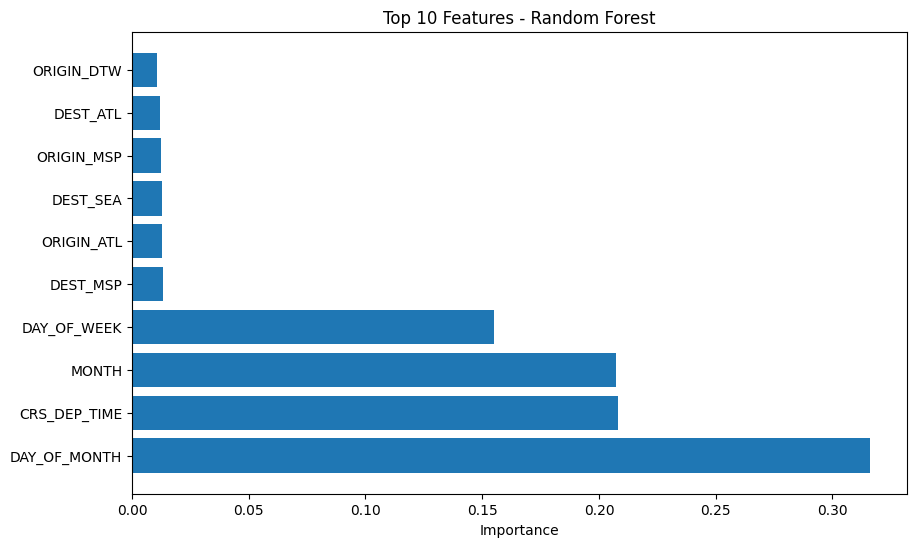

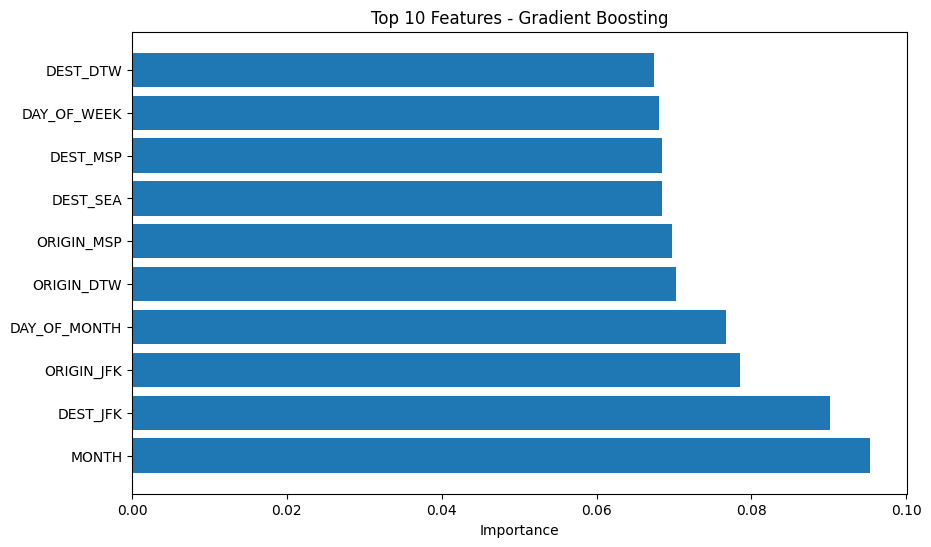

In [35]:
# Plot Random Forest feature importances
plt.figure(figsize=(10, 6))
plt.barh(df_importances_rf['Feature'][:10], df_importances_rf['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Features - Random Forest')
plt.show()

# Plot Gradient Boosting feature importances
plt.figure(figsize=(10, 6))
plt.barh(df_importances_xgb['Feature'][:10], df_importances_xgb['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Features - Gradient Boosting')
plt.show()


**Errors**

In [57]:
# Function to plot confusion matrix
def calculate_metrics_and_plot(conf_matrix, title):
    # Extracting values from confusion matrix
    true_positives = conf_matrix[1, 1]
    true_negatives = conf_matrix[0, 0]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    # Calculating accuracy
    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    # Calculating precision
    precision = true_positives / (true_positives + false_positives)

    # Calculating recall
    recall = true_positives / (true_positives + false_negatives)

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [37]:
# Get predictions from the Random Forest model
predicted_rf = model_rf.predict(X_test)

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, predicted_rf)

# Classification Report
report_rf = classification_report(y_test, predicted_rf)

# Gradient Boosting
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Classification Report
report_xgb = classification_report(y_test, y_pred_xgb)

# Neural Network
y_pred_nn = model_nn.predict(X_test)
y_pred_nn = np.round(y_pred_nn)

# Confusion Matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)

# Classification Report
report_nn = classification_report(y_test, y_pred_nn)

70/70 [==============================] - 0s 1ms/step


c:\Users\fhuur\AppData\Roaming\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fhuur\AppData\Roaming\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fhuur\AppData\Roaming\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Accuracy: 0.8751
Precision: 0.4000
Recall: 0.0752


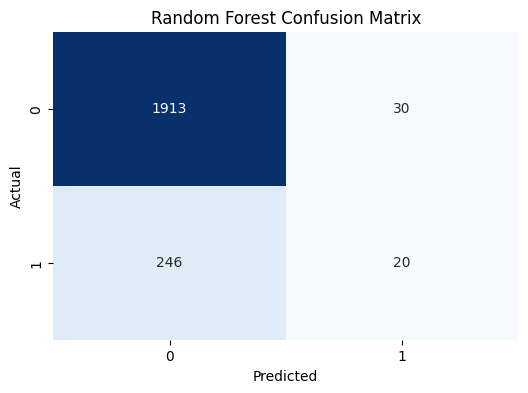

Accuracy: 0.8809
Precision: 0.5143
Recall: 0.2030


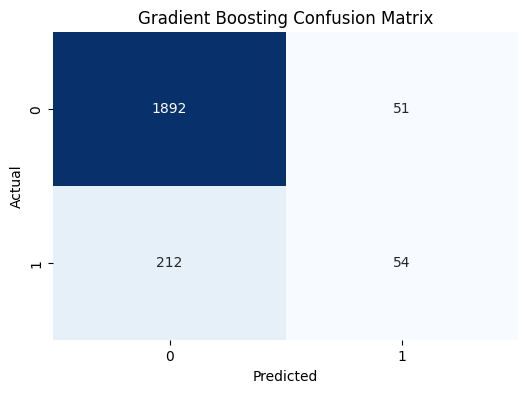

Accuracy: 0.8796
Precision: nan
Recall: 0.0000


C:\Users\fhuur\AppData\Local\Temp\ipykernel_9456\3794807639.py:13: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


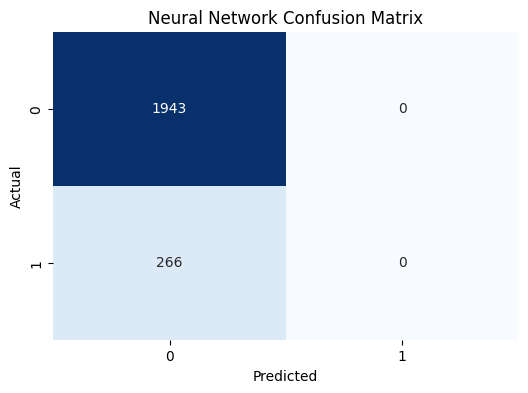

In [58]:
calculate_metrics_and_plot(conf_matrix_rf, 'Random Forest Confusion Matrix')
calculate_metrics_and_plot(conf_matrix_xgb, 'Gradient Boosting Confusion Matrix')
calculate_metrics_and_plot(conf_matrix_nn, 'Neural Network Confusion Matrix')

- ROC_AUC

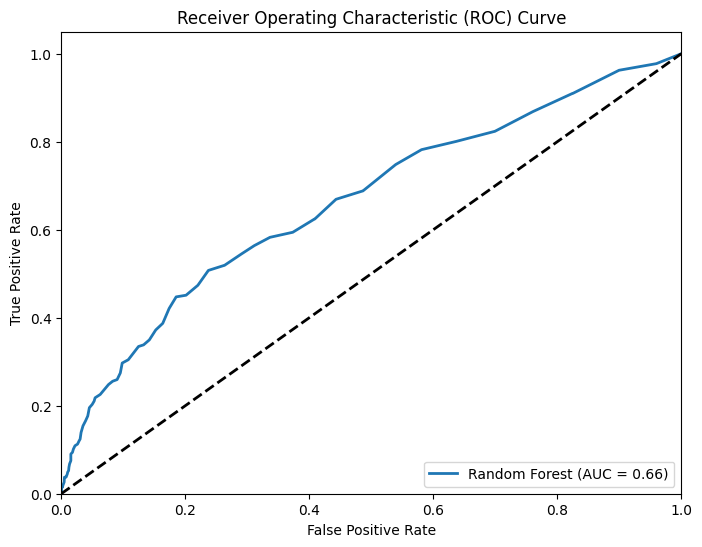

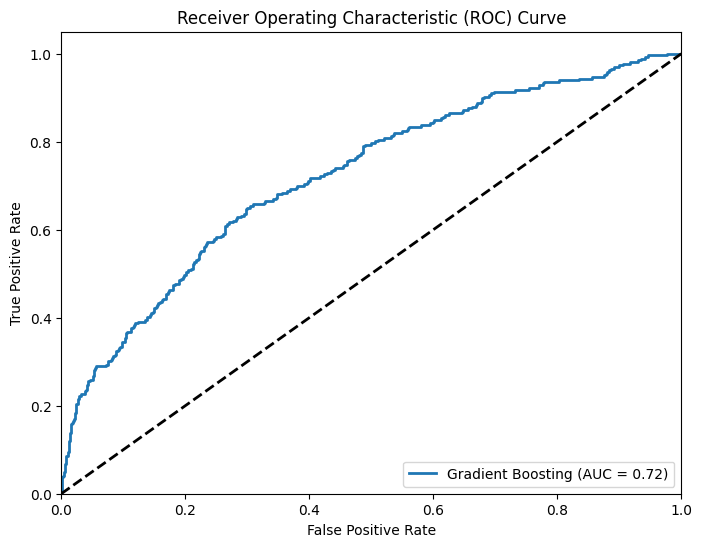

70/70 [==============================] - 0s 1ms/step


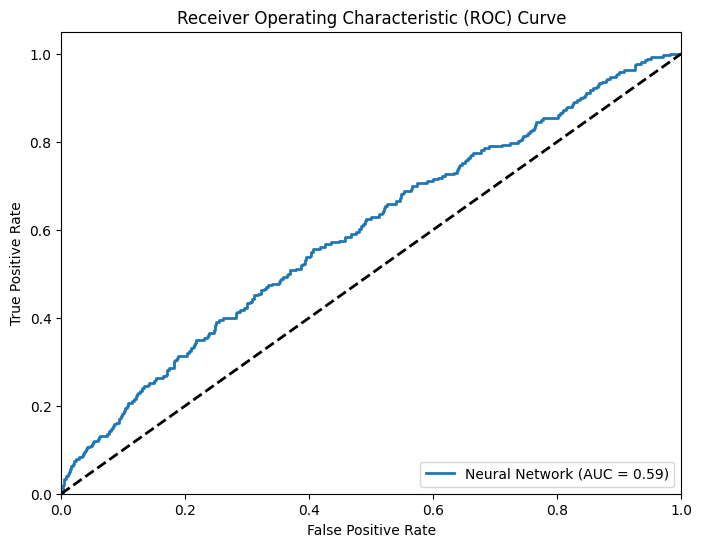

In [39]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Random Forest
y_scores_rf = model_rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores_rf, 'Random Forest')

# Gradient Boosting
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores_xgb, 'Gradient Boosting')

# Neural Network
y_scores_nn = model_nn.predict(X_test)
plot_roc_curve(y_test, y_scores_nn, 'Neural Network')

- Iteration

In [40]:
# Use Random Forest
# Get feature importances from the Random Forest model
feature_importances_rf = model_rf.feature_importances_

# Create a DataFrame to display the feature importances
df_importances_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf})
df_importances_rf = df_importances_rf.sort_values(by='Importance', ascending=False)

# Select top features (adjust the number as needed)
selected_features_rf = df_importances_rf['Feature'][:10].tolist()

# Use selected features for modeling
X_train_selected_rf = X_train[selected_features_rf]
X_test_selected_rf = X_test[selected_features_rf]


In [41]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [42]:
# Random Forest
model_rf_selected = RandomForestClassifier(random_state=13)
model_rf_selected.fit(X_train_selected_rf, y_train)

# Gradient Boosting
xgb_model_selected = XGBClassifier()
xgb_model_selected.fit(X_train_selected_rf, y_train)

# Neural Network
model_nn_selected = Sequential()
model_nn_selected.add(Dense(32, input_dim=X_train_selected_rf.shape[1], activation='relu'))
model_nn_selected.add(Dense(16, activation='relu'))
model_nn_selected.add(Dense(1, activation='sigmoid'))
model_nn_selected.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn_selected.fit(X_train_selected_rf, y_train, epochs=20, batch_size=32)


Epoch 1/20
277/277 [==============================] - 1s 2ms/step - loss: 0.4037 - accuracy: 0.8704
Epoch 2/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8745
Epoch 3/20
277/277 [==============================] - 0s 2ms/step - loss: 0.3824 - accuracy: 0.8745
Epoch 4/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3816 - accuracy: 0.8745
Epoch 5/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3832 - accuracy: 0.8745
Epoch 6/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3774 - accuracy: 0.8745
Epoch 7/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3753 - accuracy: 0.8745
Epoch 8/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3767 - accuracy: 0.8745
Epoch 9/20
277/277 [==============================] - 0s 2ms/step - loss: 0.3740 - accuracy: 0.8745
Epoch 10/20
277/277 [==============================] - 1s 2ms/step - loss: 0.3734 - accuracy: 0.8745

In [43]:
# Performance

# Random Forest
accuracy_rf_selected = model_rf_selected.score(X_test_selected_rf, y_test)
print(f'Random Forest Accuracy: {accuracy_rf_selected}')

# Gradient Boosting
y_pred_xgb_selected = xgb_model_selected.predict(X_test_selected_rf)
accuracy_xgb_selected = accuracy_score(y_test, y_pred_xgb_selected)
print(f'Gradient Boosting Accuracy: {accuracy_xgb_selected}')

# Neural Network
y_pred_nn_selected = model_nn_selected.predict(X_test_selected_rf)
y_pred_nn_selected = np.round(y_pred_nn_selected)
accuracy_nn_selected = accuracy_score(y_test, y_pred_nn_selected)
print(f'Neural Network Accuracy: {accuracy_nn_selected}')



Random Forest Accuracy: 0.87324581258488
Gradient Boosting Accuracy: 0.8764146672702581
70/70 [==============================] - 0s 1ms/step
Neural Network Accuracy: 0.879583521955636


In [44]:
# Errors

# Random Forest
predicted_rf_selected = model_rf_selected.predict(X_test_selected_rf)
conf_matrix_rf_selected = confusion_matrix(y_test, predicted_rf_selected)
report_rf_selected = classification_report(y_test, predicted_rf_selected)
print('Random Forest Confusion Matrix:')
print(conf_matrix_rf_selected)
print('Random Forest Classification Report:')
print(report_rf_selected)

# Gradient Boosting
conf_matrix_xgb_selected = confusion_matrix(y_test, y_pred_xgb_selected)
report_xgb_selected = classification_report(y_test, y_pred_xgb_selected)
print('Gradient Boosting Confusion Matrix:')
print(conf_matrix_xgb_selected)
print('Gradient Boosting Classification Report:')
print(report_xgb_selected)

# Neural Network
conf_matrix_nn_selected = confusion_matrix(y_test, y_pred_nn_selected)
report_nn_selected = classification_report(y_test, y_pred_nn_selected)
print('Neural Network Confusion Matrix:')
print(conf_matrix_nn_selected)
print('Neural Network Classification Report:')
print(report_nn_selected)


Random Forest Confusion Matrix:
[[1904   39]
 [ 241   25]]
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      1943
         1.0       0.39      0.09      0.15       266

    accuracy                           0.87      2209
   macro avg       0.64      0.54      0.54      2209
weighted avg       0.83      0.87      0.84      2209

Gradient Boosting Confusion Matrix:
[[1887   56]
 [ 217   49]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      1943
         1.0       0.47      0.18      0.26       266

    accuracy                           0.88      2209
   macro avg       0.68      0.58      0.60      2209
weighted avg       0.85      0.88      0.85      2209

Neural Network Confusion Matrix:
[[1943    0]
 [ 266    0]]
Neural Network Classification Report:
              precision    recall  f1-score   su

c:\Users\fhuur\AppData\Roaming\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fhuur\AppData\Roaming\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fhuur\AppData\Roaming\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

# Fine tune

In [45]:
# Random Forest
# Define hyperparameters to tune
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model
rf_model = RandomForestClassifier(random_state=13)

# Use GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_selected_rf, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print('Best Hyperparameters for Random Forest:', best_params_rf)

# Train the model with the best hyperparameters
final_model_rf = grid_search_rf.best_estimator_

Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [46]:
# Gradient Boosting 
# Define hyperparameters to tune
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create Gradient Boosting model
xgb_model_tuned = XGBClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(xgb_model_tuned, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train_selected_rf, y_train)

# Get the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print('Best Hyperparameters for Gradient Boosting:', best_params_xgb)

# Train the model with the best hyperparameters
final_model_xgb = grid_search_xgb.best_estimator_

Best Hyperparameters for Gradient Boosting: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}


In [47]:
# Neural Network
# Define hyperparameters to tune
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), input_dim=X_train_selected_rf.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='tuner_results', project_name='neural_network_tuning')

# Search for the best hyperparameters
tuner.search(X_train_selected_rf, y_train, epochs=10, validation_data=(X_test_selected_rf, y_test))

# Get the best hyperparameters
best_params_nn = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
print('Best Hyperparameters for Neural Network:', best_params_nn)

# Build the final model with the best hyperparameters
final_model_nn = tuner.get_best_models(1)[0]

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.8795835375785828

Best val_accuracy So Far: 0.8800362348556519
Total elapsed time: 00h 02m 13s
Best Hyperparameters for Neural Network: {'units': 288}


In [48]:
# Performance
# Random Forest
accuracy_rf_final = final_model_rf.score(X_test_selected_rf, y_test)
print(f'Final Random Forest Accuracy on Test Set: {accuracy_rf_final}')

# Gradient Boosting
y_pred_xgb_final = final_model_xgb.predict(X_test_selected_rf)
accuracy_xgb_final = accuracy_score(y_test, y_pred_xgb_final)
print(f'Final Gradient Boosting Accuracy on Test Set: {accuracy_xgb_final}')

# Neural Network
y_pred_nn_final = final_model_nn.predict(X_test_selected_rf)
y_pred_nn_final = np.round(y_pred_nn_final)
accuracy_nn_final = accuracy_score(y_test, y_pred_nn_final)
print(f'Final Neural Network Accuracy on Test Set: {accuracy_nn_final}')


Final Random Forest Accuracy on Test Set: 0.8813942960615663
Final Gradient Boosting Accuracy on Test Set: 0.8836577636939792
70/70 [==============================] - 0s 2ms/step
Final Neural Network Accuracy on Test Set: 0.8809416025350838


# Use it

Let's try the models we trained

In [61]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(
            departure_date_time, "%d/%m/%Y %H:%M:%S"
        )
    except ValueError as e:
        return "Error parsing date/time - {}".format(e)

    month = departure_date_time_parsed.month
    day_of_month = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [
        {
            "MONTH": month,
            "DAY_OF_MONTH": day_of_month,  # Corrected feature name
            "DAY_OF_WEEK": day_of_week,
            "CRS_DEP_TIME": hour,
            "ORIGIN_ATL": 1 if origin == "ATL" else 0,
            "ORIGIN_DTW": 1 if origin == "DTW" else 0,
            "ORIGIN_JFK": 1 if origin == "JFK" else 0,
            "ORIGIN_MSP": 1 if origin == "MSP" else 0,
            "ORIGIN_SEA": 1 if origin == "SEA" else 0,
            "DEST_ATL": 1 if destination == "ATL" else 0,
            "DEST_DTW": 1 if destination == "DTW" else 0,
            "DEST_JFK": 1 if destination == "JFK" else 0,
            "DEST_MSP": 1 if destination == "MSP" else 0,
            "DEST_SEA": 1 if destination == "SEA" else 0,
        }
    ]

    return xgb_model.predict_proba(pd.DataFrame(input))[0][0]

In [54]:
predict_delay('1/10/2018 11:45:00', 'JFK', 'ATL')

0.97520715

In [55]:
predict_delay('2/10/2018 21:45:00', 'SEA', 'ATL')

0.99870294

(0.0, 1.0)

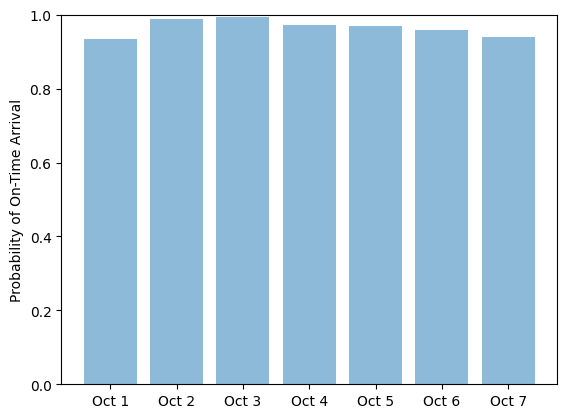

In [62]:
labels = ("Oct 1", "Oct 2", "Oct 3", "Oct 4", "Oct 5", "Oct 6", "Oct 7")
values = (
    predict_delay("1/10/2018 21:45:00", "JFK", "ATL"),
    predict_delay("2/10/2018 21:45:00", "JFK", "ATL"),
    predict_delay("3/10/2018 21:45:00", "JFK", "ATL"),
    predict_delay("4/10/2018 21:45:00", "JFK", "ATL"),
    predict_delay("5/10/2018 21:45:00", "JFK", "ATL"),
    predict_delay("6/10/2018 21:45:00", "JFK", "ATL"),
    predict_delay("7/10/2018 21:45:00", "JFK", "ATL"),
)
alabels = np.arange(len(labels))

plt.bar(alabels, values, align="center", alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel("Probability of On-Time Arrival")
plt.ylim((0.0, 1.0))

# Video Presentation

Link: https://youtu.be/QT1aB8Ljnbc